In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import scipy
from itertools import product
from scipy.spatial.transform import Rotation
from mpl_toolkits.mplot3d import Axes3D
import utils

In [2]:
R1 = np.eye(3, 3)
R2 = np.eye(3, 3)

t1 = np.array([[0, 0, 1]])
t2 = np.array([[0, 0, 20]])

K1 = np.array([[700, 0, 600],
              [0, 700, 400],
              [0, 0, 1]])

K2 = K1.copy()

Q = np.array([[1, 1, 0]]).T

In [3]:
P1 = utils.getP(K1, R1, t1)
P2 = utils.getP(K2, R2, t2)

q1 = utils.Pi(P1 @ utils.PiInv(Q))
q2 = utils.Pi(P2 @ utils.PiInv(Q))

print(q1)
print(q2)

[[1300.]
 [1100.]]
[[635.]
 [435.]]


In [4]:
noise = np.array([[1], [-1]])
q1n = q1 + noise
q2n = q2 + noise

qn = np.concatenate((q1n, q2n), axis=1)
Q_ = utils.triangulate(qn, [P1, P2])

q1_ = utils.Pi(P1 @ Q_)
q2_ = utils.Pi(P2 @ Q_)

print(f'Error in cam 1: {np.linalg.norm(q1_ - q1)}')
print(f'Error in cam 2: {np.linalg.norm(q2_ - q2)}')
print(f'Q tilde:\n {utils.Pi(Q_)}')
print(f'Error in Q: {np.linalg.norm(Q - utils.Pi(Q_))}')

Error in cam 1: 14.847231966697533
Error in cam 2: 0.7426731182710001
Q tilde:
 [[1.01527507e+00]
 [9.85270570e-01]
 [2.85786810e-04]]
Error in Q: 0.02122181735338073


5.3

In [5]:
def triangulate_nonlin(q, P):
    def compute_residuals(Q):
        residuals = []
        for i in range(len(P)):
            residuals.append((utils.Pi(P[i] @ np.expand_dims(Q, axis=0).T) -
                             np.expand_dims(q[:,i], axis=0).T).flatten())
        return np.array(residuals).flatten()
    Q_ = utils.triangulate(q, P).flatten()
    Q_ = scipy.optimize.least_squares(compute_residuals, Q_)
    return Q_

In [6]:
Qhat = triangulate_nonlin(qn, [P1, P2])
Qhat = np.expand_dims(Qhat.x, axis=0).T
print(f'Q hat:\n {utils.Pi(Qhat)}')
print(f'Error in Q: {np.linalg.norm(Q - utils.Pi(Qhat))}')

Q hat:
 [[1.00153897e+00]
 [9.98546322e-01]
 [4.27494784e-05]]
Error in Q: 0.002117415329729317


Camera calibration with OpenCV

In [7]:
def checkerboard_points(n, m):
    Q = []
    for i in range(n):
        for j in range(m):
            Q.append(np.array([[i-(n-1)/2, j-(m-1)/2, 0]]).astype(np.float32))
    return np.vstack(Q).T

In [35]:
root = 'calib/'
q = []
scale = 0.25
imsize = None
imgs = []
for i in range(64, 84):
    im = cv2.imread(root + f'IMG_00{i}.jpg')[:,:,::-1]
    im = cv2.resize(im, None, fx=scale, fy=scale)
    if not imsize: imsize = im.shape
    imgs.append(im)

to_del = []
for i, im in enumerate(imgs):
    res = cv2.findChessboardCorners(im, (7, 10))
    if not res[0]:
        print(f'No corners found for IMG_00{i+64}.jpg')
        to_del.append(i)
    else:
        q.append(res[1])

# delete images for which no corners were found
to_del.sort(reverse=True)
for index in to_del:
    del imgs[index]

No corners found for IMG_0069.jpg
No corners found for IMG_0083.jpg


In [36]:
print(imsize[1::-1])

(1008, 756)


In [51]:
Q = checkerboard_points(10, 7).T
Qs = []
for i in range(len(q)):
    Qs.append(Q)

flags = cv2.CALIB_FIX_K1+cv2.CALIB_FIX_K2+cv2.CALIB_FIX_K3+cv2.CALIB_FIX_K4+cv2.CALIB_FIX_K5+cv2.CALIB_FIX_K6+cv2.CALIB_ZERO_TANGENT_DIST
ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(Qs, q, imsize[1::-1], None, None, flags=flags)

print(ret)
print(K)

0.9568510733156048
[[407.71329638   0.         503.24977923]
 [  0.         407.76111607 374.40060814]
 [  0.           0.           1.        ]]


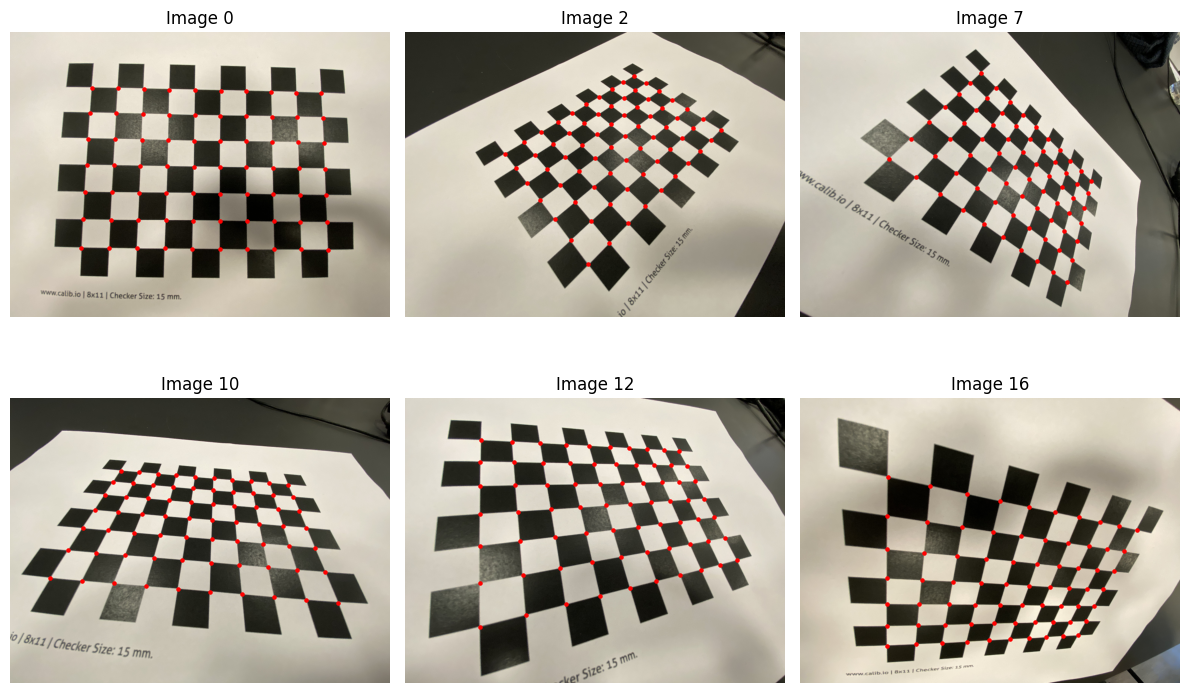

In [52]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
idxs = [0, 2, 7, 10, 12, 16]
for i, idx in enumerate(idxs):
    row = i // 3
    col = i % 3
    ax = axes[row, col]

    # Plot image
    ax.imshow(imgs[idx])

    R = cv2.Rodrigues(rvecs[idx])[0]
    t = tvecs[idx].T

    proj = utils.projectpoints(K, R, t, Q.T, [])

    # Plot projected points
    ax.scatter(proj[0], proj[1], marker='o', color='r', s=5)

    ax.set_title(f'Image {idx}')
    ax.axis('off')

plt.tight_layout()
plt.show()


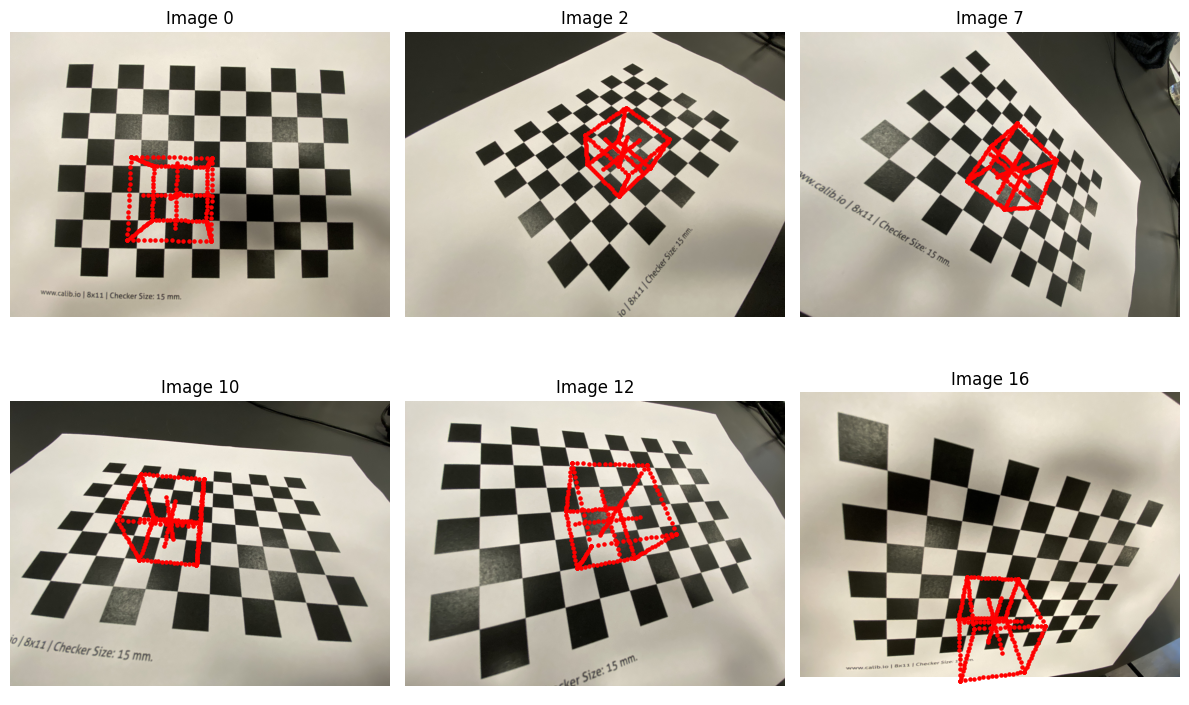

In [53]:
import itertools as it
def box3d(n=16):
    points = []
    N = tuple(np.linspace(-1, 1, n))
    for i, j in [(-1, -1), (-1, 1), (1, 1), (0, 0)]:
        points.extend(set(it.permutations([(i, )*n, (j, )*n, N])))
    return np.hstack(points)/2

Qbox = 2*box3d() + 1

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
idxs = [0, 2, 7, 10, 12, 16]
for i, idx in enumerate(idxs):
    row = i // 3
    col = i % 3
    ax = axes[row, col]

    # Plot image
    ax.imshow(imgs[idx])

    R = cv2.Rodrigues(rvecs[idx])[0]
    t = tvecs[idx].T

    proj = utils.projectpoints(K, R, t, Qbox, [])

    # Plot projected points
    ax.scatter(proj[0], proj[1], marker='o', color='r', s=5)

    ax.set_title(f'Image {idx}')
    ax.axis('off')

plt.tight_layout()
plt.show()